<h2><font color="#004D7F" size=6>TCGA Data Analysis </font></h2>
<h3><font color="#004D7F" size=4>- Jorge Iván Díaz Riaño PhD(c)  </font></h3>

<h1><font color="#004D7F" size=4>1. Loading and preprocessing data</font></h1>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Loading required packages and libraries
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [3]:
dataset='/home/jorge-diaz/Documents/TCGA/TC3Rpipeline/TCGA-GBMmage_tpm_plus_clinical.csv'
data= pd.read_csv(dataset, sep=',')
df = pd.DataFrame(data)
# replace empty/invalid values with NaN
df.replace("\'--", np.nan, inplace=True)
df.replace('not reported', np.nan, inplace=True)
df.replace('Not Reported', np.nan, inplace=True)
df.head(2)

,sample,ENSG00000046774,ENSG00000099399,ENSG00000102316,ENSG00000120289,ENSG00000123584,ENSG00000124260,ENSG00000130726,ENSG00000147381,ENSG00000154545,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,TCGA-02-0047,0.0482,0.0598,337.5721,0.0,0.0,0.0000,193.3670,0.1248,2.8987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,"Pharmaceutical Therapy, NOS"
1,TCGA-02-0055,0.2301,0.1428,349.1256,0.0,0.0,0.0264,155.1753,0.0248,0.9224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Radiation Therapy, NOS"


In [4]:
#Cross GO code with Gene names
dataset2='/home/jorge-diaz/Documents/TCGA/TC3Rpipeline/TCGA-06-0132-01A'
df2 = pd.read_csv(dataset2, sep='\t',header=1, index_col=0)
df2.index = df2.index.str.split(".").str[0]
df2

# Create a dictionary to cross gene names and GO code
column_mapping = {}
for column_name in df.columns:
    for column_value in df2.index:
        if column_value in column_name:
            column_mapping[column_name] = df2.loc[column_value, 'gene_name']
            break

# Rename columns on dataset1
df.rename(columns=column_mapping, inplace=True)
df.head(2)

,sample,MAGEC2,MAGEB2,MAGED2,MAGEB4,MAGEA9,MAGEA10,TRIM28,MAGEA4,MAGED4,...,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,TCGA-02-0047,0.0482,0.0598,337.5721,0.0,0.0,0.0000,193.3670,0.1248,2.8987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,NaN,"Pharmaceutical Therapy, NOS"
1,TCGA-02-0055,0.2301,0.1428,349.1256,0.0,0.0,0.0264,155.1753,0.0248,0.9224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yes,NaN,"Radiation Therapy, NOS"


In [5]:
# Count of null data points
print(df.isnull().sum())

sample                     0
MAGEC2                     0
MAGEB2                     0
MAGED2                     0
MAGEB4                     0
                        ... 
treatment_frequency      169
treatment_intent_type    169
treatment_or_therapy       9
treatment_outcome        169
treatment_type             1
Length: 200, dtype: int64


In [6]:
# drop columns with >0.8 NaN's
df = df.loc[:, df.isnull().mean() < .8]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169 entries, 0 to 168
Data columns (total 66 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sample                       169 non-null    object 
 1   MAGEC2                       169 non-null    float64
 2   MAGEB2                       169 non-null    float64
 3   MAGED2                       169 non-null    float64
 4   MAGEB4                       169 non-null    float64
 5   MAGEA9                       169 non-null    float64
 6   MAGEA10                      169 non-null    float64
 7   TRIM28                       169 non-null    float64
 8   MAGEA4                       169 non-null    float64
 9   MAGED4                       169 non-null    float64
 10  MAGEC1                       169 non-null    float64
 11  MAGEA8                       169 non-null    float64
 12  MAGEC3                       169 non-null    float64
 13  MAGEB6              

In [7]:
df.describe()

,MAGEC2,MAGEB2,MAGED2,MAGEB4,MAGEA9,MAGEA10,TRIM28,MAGEA4,MAGED4,MAGEC1,...,MAGEB1,MAGEA3,MAGEA7P,MAGEA5,CSAG4,MAGEL2,MAGEA9B,MAGEA2,CSAG2,CSAG3
count,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,...,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000,169.000000
mean,1.376357,0.051341,332.688191,0.001377,0.016925,0.008455,262.901669,0.094802,2.262738,0.221644,...,0.010230,0.165129,0.004552,0.001862,0.077508,3.807359,0.137654,0.003274,0.144398,0.442263
std,10.909120,0.178642,148.870570,0.006667,0.139242,0.044131,112.424443,1.108619,1.567896,1.721479,...,0.025068,0.640966,0.019571,0.014376,0.108612,6.612708,1.708135,0.011815,1.024924,2.377070
min,0.000000,0.000000,151.831300,0.000000,0.000000,0.000000,67.721500,0.000000,0.300200,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.125500,0.000000,0.000000,0.000000,0.000000
25%,0.034000,0.000000,258.648100,0.000000,0.000000,0.000000,177.140100,0.000000,1.216400,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.169100,0.000000,0.000000,0.000000,0.000000
50%,0.076200,0.000000,304.957300,0.000000,0.000000,0.000000,249.135300,0.000000,2.007400,0.019700,...,0.000000,0.040300,0.000000,0.000000,0.000000,2.394000,0.000000,0.000000,0.000000,0.080900
75%,0.181000,0.052100,358.003300,0.000000,0.000000,0.000000,325.502600,0.000000,2.956400,0.049100,...,0.000000,0.095800,0.000000,0.000000,0.111100,3.604200,0.000000,0.000000,0.060800,0.220500
max,137.858300,2.162600,1327.617000,0.037100,1.334800,0.457900,728.133100,14.410900,14.655400,21.838400,...,0.166400,6.552200,0.120600,0.143900,0.604300,68.194500,22.202800,0.080900,12.231800,30.063700


In [8]:
df.set_index('sample', inplace=True)

In [9]:
df

,MAGEC2,MAGEB2,MAGED2,MAGEB4,MAGEA9,MAGEA10,TRIM28,MAGEA4,MAGED4,MAGEC1,...,days_to_last_follow_up,icd_10_code,morphology,primary_diagnosis,prior_treatment,site_of_resection_or_biopsy,tissue_or_organ_of_origin,year_of_diagnosis,treatment_or_therapy,treatment_type
sample,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047,0.0482,0.0598,337.5721,0.0,0.0,0.0000,193.3670,0.1248,2.8987,0.0904,...,448,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,no,"Pharmaceutical Therapy, NOS"
TCGA-02-0055,0.2301,0.1428,349.1256,0.0,0.0,0.0264,155.1753,0.0248,0.9224,0.0180,...,76,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,yes,"Radiation Therapy, NOS"
TCGA-02-2483,1.0924,0.0000,358.0033,0.0,0.0,0.0000,425.5501,0.0000,0.9859,0.2108,...,466,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2008,yes,"Pharmaceutical Therapy, NOS"
TCGA-02-2485,0.1313,0.0000,364.7759,0.0,0.0,0.0000,487.4934,0.0000,1.7063,0.0410,...,470,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2009,yes,"Pharmaceutical Therapy, NOS"
TCGA-02-2486,0.1287,0.0532,308.1803,0.0,0.0,0.0000,171.9205,0.0000,0.4980,0.0804,...,493,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2008,yes,"Radiation Therapy, NOS"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-76-4927,0.1259,0.1562,321.0492,0.0,0.0,0.0433,371.4325,0.0000,2.5577,0.0295,...,535,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,NaN,"Radiation Therapy, NOS"
TCGA-76-4928,0.0916,0.0000,274.2622,0.0,0.0,0.0000,190.8421,0.0000,2.6967,0.0286,...,94,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,yes,"Pharmaceutical Therapy, NOS"
TCGA-76-4929,0.2162,0.0000,399.9457,0.0,0.0,0.0000,201.0925,0.0000,3.2269,0.1013,...,111,C71.9,9440/3,Glioblastoma,No,"Brain, NOS","Brain, NOS",2005,NaN,"Pharmaceutical Therapy, NOS"


<h1><font color="#004D7F" size=5>2. Visualization</font></h1>

<h1><font color="#004D7F" size=4>2.1 Correlation.</font></h1>

In [10]:
df_numeric = df.select_dtypes(include=['number'])
# Reorder columns based on the provided order
column_order = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28"
]
df_numeric = df_numeric[column_order]

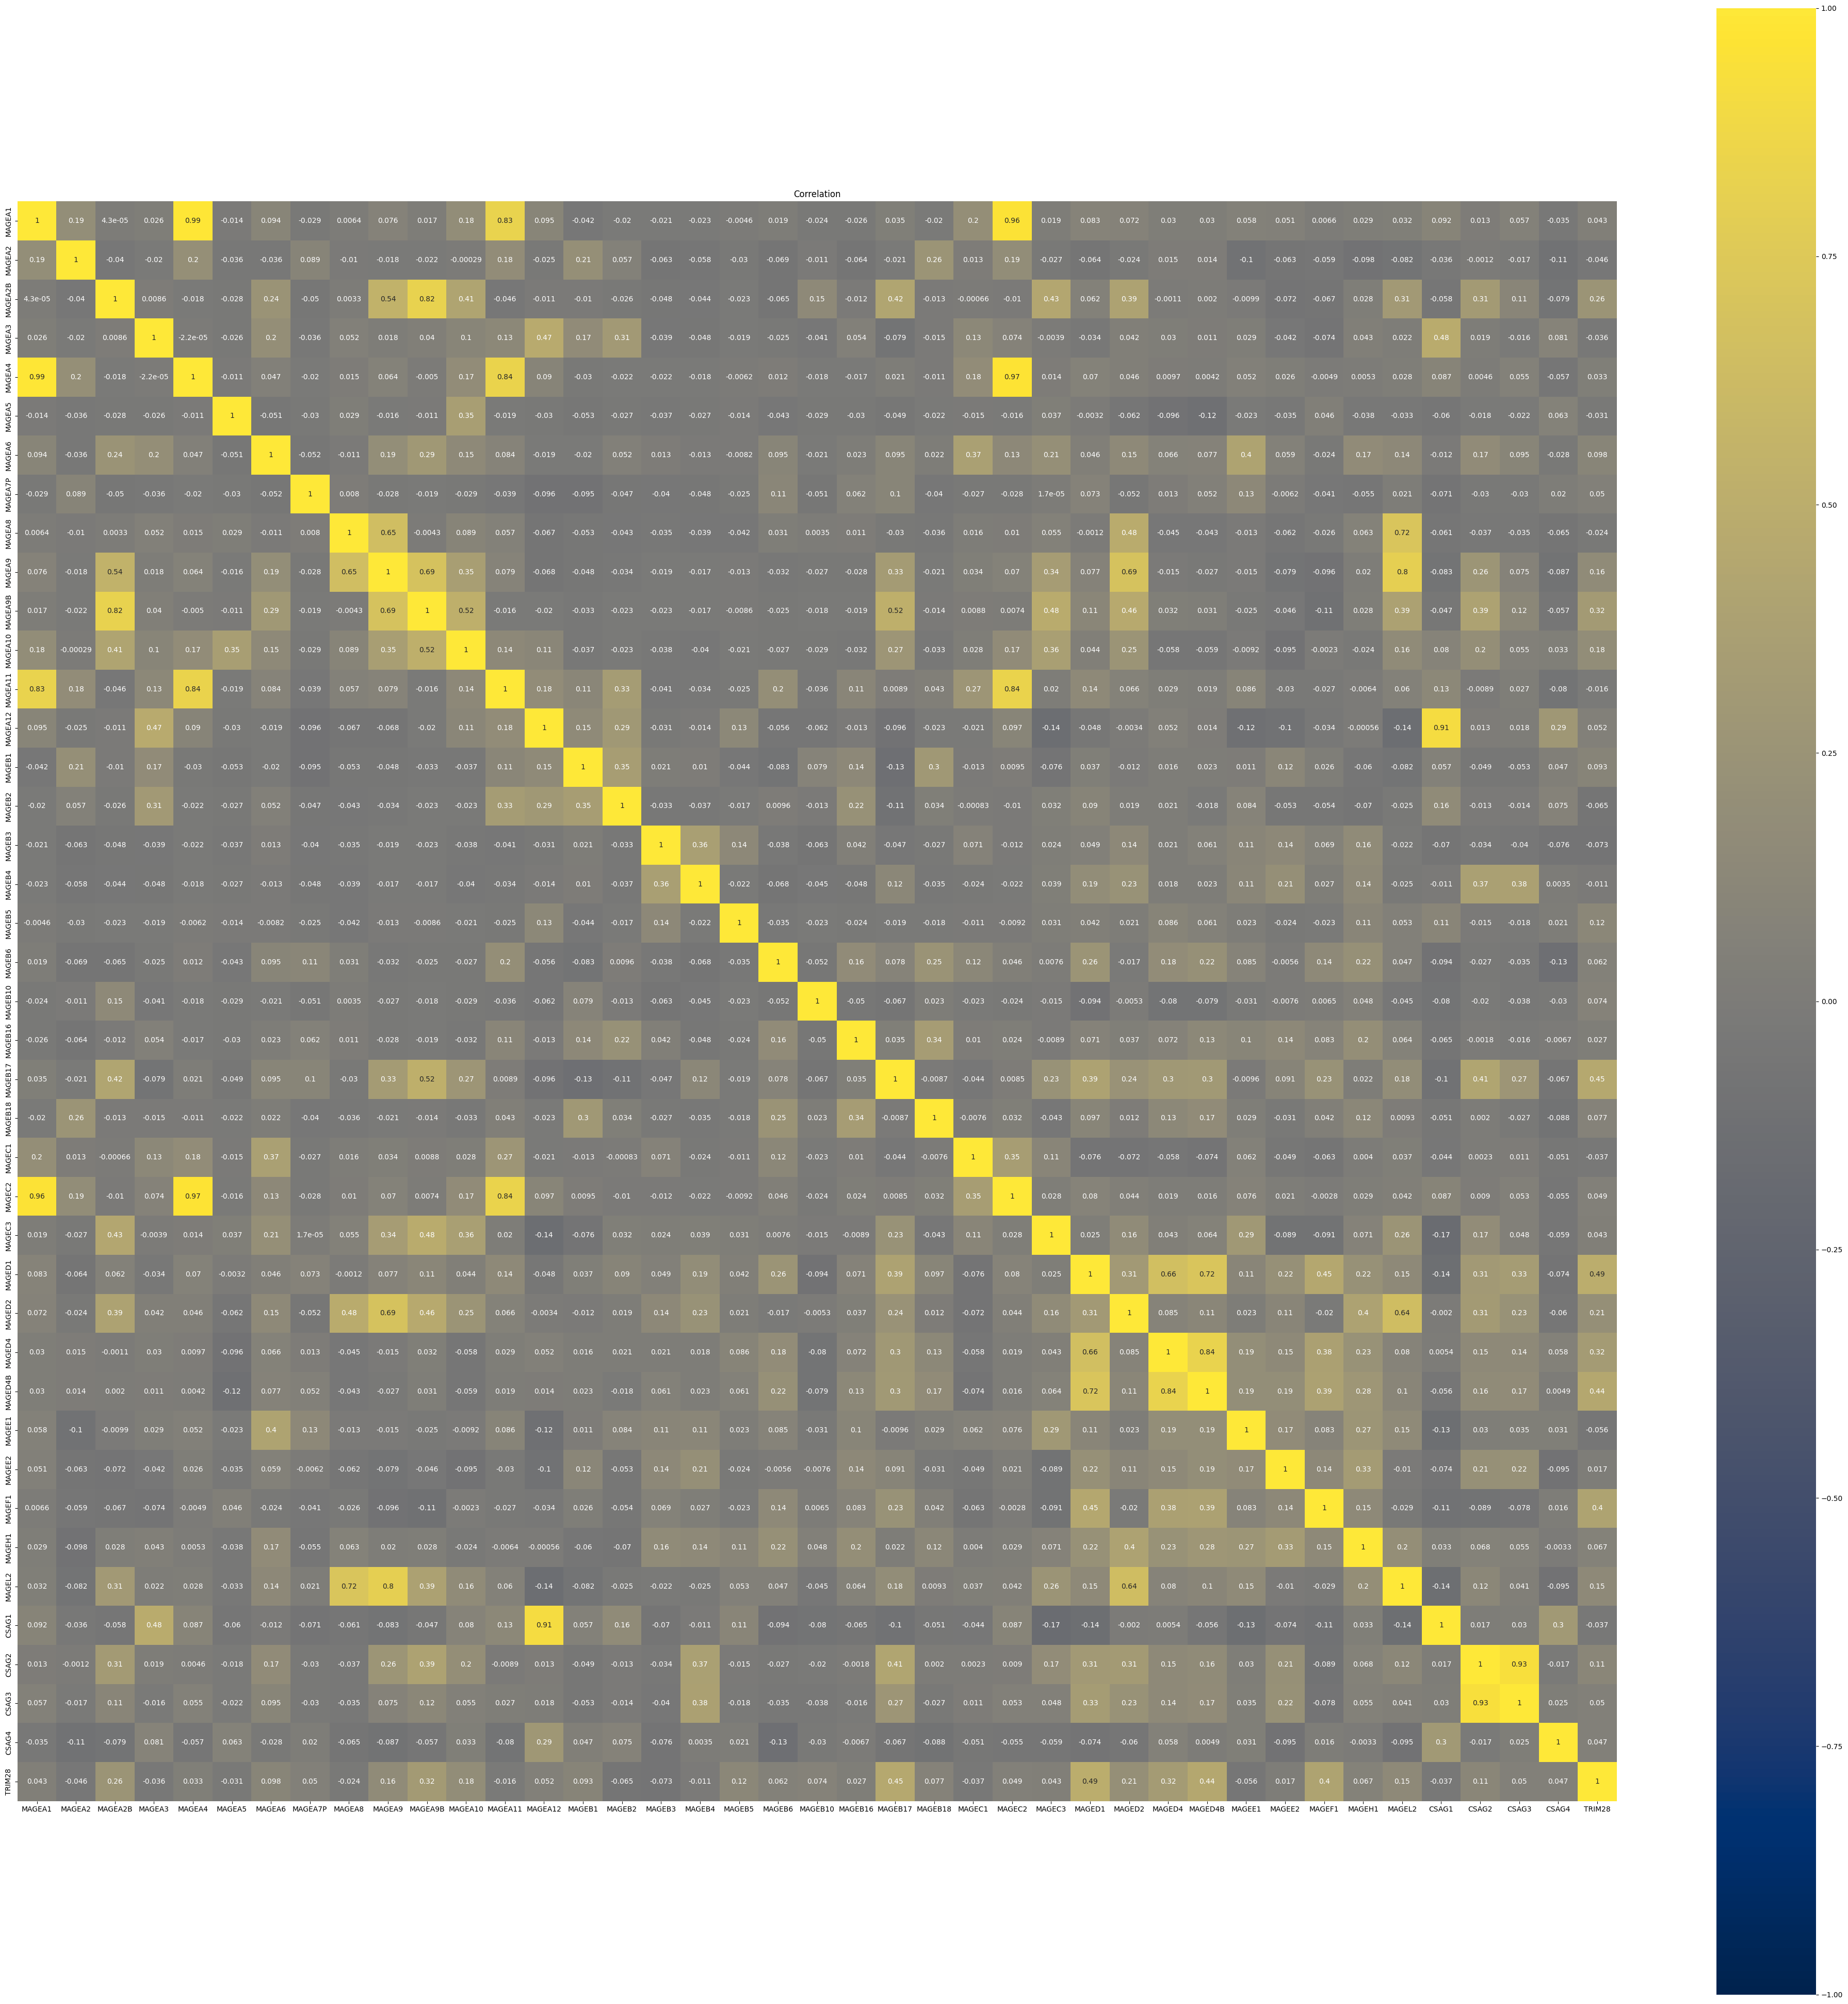

In [11]:
#Perform correlation (Pearson)
correlation = df_numeric.corr()
plt.figure(figsize = (50,50))
ax = sns.heatmap(correlation, vmax = 1, vmin = -1, square=True , annot=True, cmap = 'cividis') #Correlations from -1 to 1m change to vmin
correlation.to_csv('MAGEsPearsonCorrelation.csv')
plt.title('Correlation')
plt.show()

In [12]:
#Obtain top correlations. Functions to calculate.
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

def get_all_abs_correlations(df):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

In [13]:
print(get_top_abs_correlations(df_numeric, 14))

MAGEA1   MAGEA4     0.985519
MAGEA4   MAGEC2     0.968048
MAGEA1   MAGEC2     0.959018
CSAG2    CSAG3      0.934754
MAGEA12  CSAG1      0.907400
MAGEA11  MAGEC2     0.841618
MAGEA4   MAGEA11    0.838770
MAGED4   MAGED4B    0.835517
MAGEA1   MAGEA11    0.829848
MAGEA2B  MAGEA9B    0.822867
MAGEA9   MAGEL2     0.804245
MAGEA8   MAGEL2     0.715260
MAGED1   MAGED4B    0.715195
MAGEA9   MAGEA9B    0.691784
dtype: float64


<h1><font color="#004D7F" size=4>2.2 Distribution of TPMs.</font></h1>

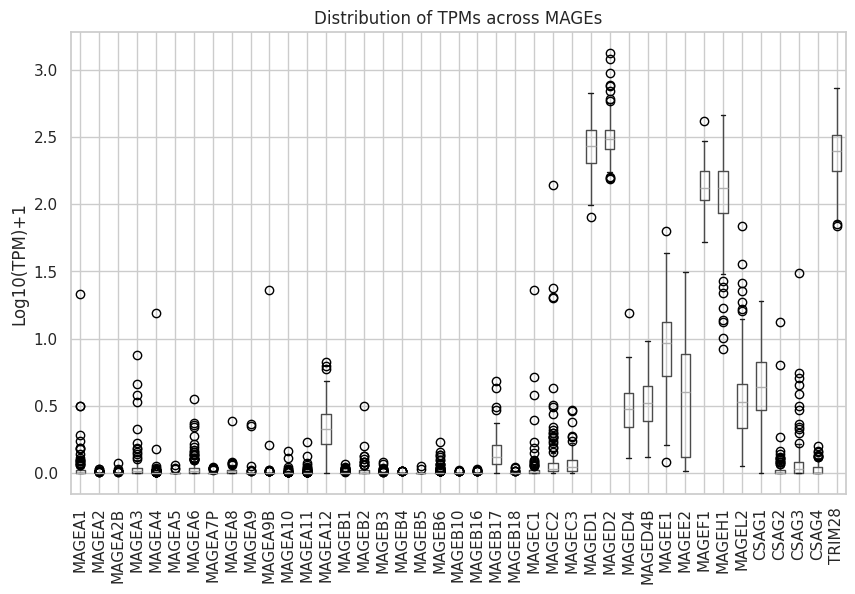

In [29]:
plt.figure(figsize=(10, 6))
df_numeric_log10 = np.log10(df_numeric+1)
df_numeric_log10.boxplot(rot=90)
plt.title('Distribution of TPMs across MAGEs')
plt.ylabel('Log10(TPM)+1')
plt.show()

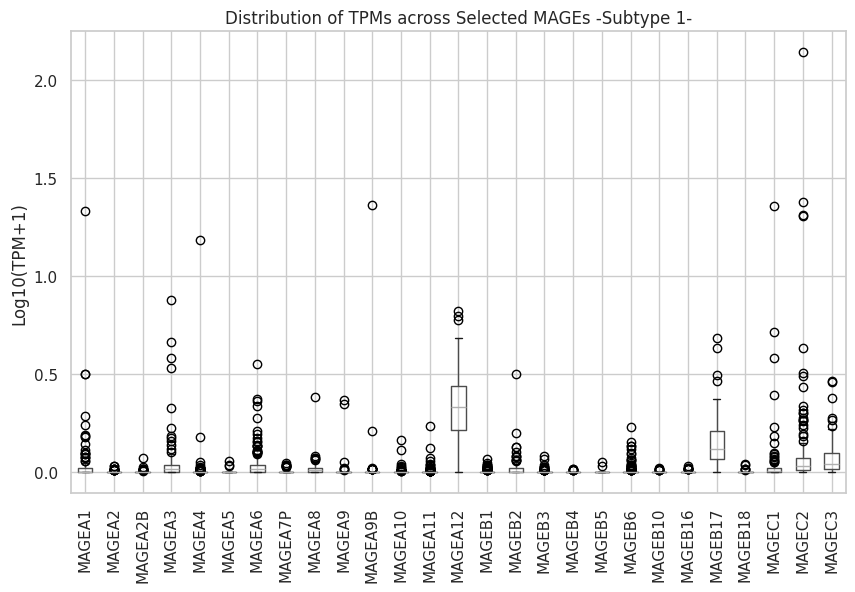

In [30]:
# Define the order of MAGE genes to include
mage_genes_subset = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3"
]
# Filter dataframe to include only the specified MAGE genes
df_numeric_subset = df_numeric[mage_genes_subset]
# Plotting
plt.figure(figsize=(10, 6))
df_numeric_log10 = np.log10(df_numeric_subset + 1)
df_numeric_log10.boxplot(rot=90)
plt.title('Distribution of TPMs across Selected MAGEs -Subtype 1-')
plt.ylabel('Log10(TPM+1)')
plt.show()

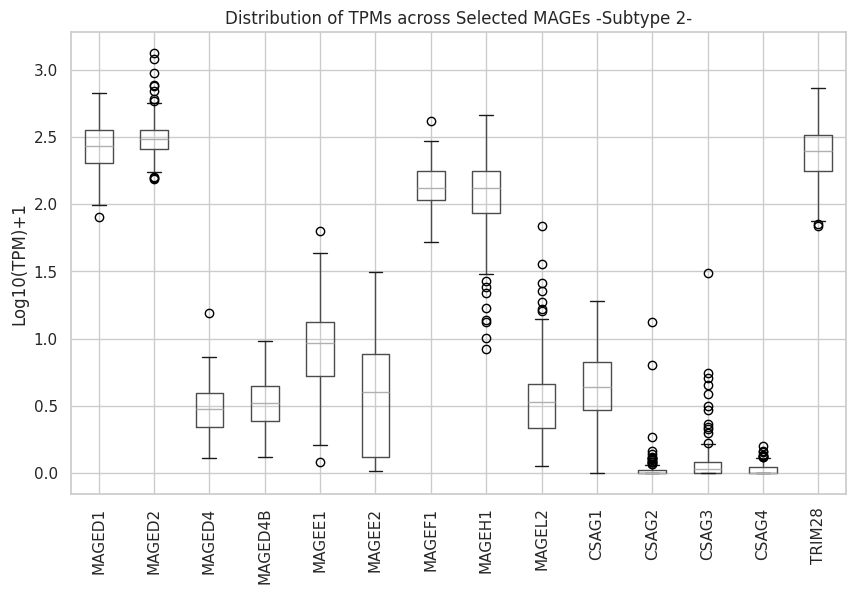

In [31]:
# Define the order of MAGE genes to include
mage_genes_subset = [
    "MAGED1", "MAGED2", "MAGED4", "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", 
    "CSAG3", "CSAG4", "TRIM28"
]
# Filter dataframe to include only the specified MAGE genes
df_numeric_subset = df_numeric[mage_genes_subset]
# Plotting
plt.figure(figsize=(10, 6))
df_numeric_log10 = np.log10(df_numeric_subset + 1)
df_numeric_log10.boxplot(rot=90)
plt.title('Distribution of TPMs across Selected MAGEs -Subtype 2-')
plt.ylabel('Log10(TPM)+1')
plt.show()

<h1><font color="#004D7F" size=4>2.3 Composition of Positive and Negative Tumors by MAGEs.</font></h1>

In [25]:
no_zero = df_numeric.astype(bool).sum(axis=0)
zero = df_numeric.shape[0] - no_zero
# New df to order output
output_df = pd.DataFrame({'Positive_counts': no_zero, 'Negative_counts': zero})
# Add total count columncolumnsHistogram = ['age_at_index', 'days_to_birth', 'days_to_death', 'year_of_birth', 'year_of_death', 'age_at_diagnosis', 'days_to_diagnosis', 
    'days_to_last_follow_up', 'year_of_diagnosis']
columnsBar = ['ethnicity', 'gender', 'race', 'vital_status', 'treatment_or_therapy', 'treatment_type']

# Histograms
for column in columnsHistogram:
    plt.figure(figsize=(8, 6))
    plt.hist(df[column], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

# Bar plots
for column in columnsBar:
    plt.figure(figsize=(8, 6))
    df[column].value_counts().plot(kind='bar', color='lightcoral', edgecolor='black')
    plt.title(f'Bar plot of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
output_df['Total_counts'] = output_df['Positive_counts'] + output_df['Negative_counts']
# Calculate percentages
percentage_df = output_df[['Positive_counts', 'Negative_counts']].div(output_df['Total_counts'], axis=0) * 100
# Concatenate percentages with original DataFrame
output_df = pd.concat([output_df, percentage_df.add_suffix('_percentage')], axis=1)
# Sort DataFrame by column names (alphabetical order)
output_df = output_df.sort_index()
finalTable= output_df[['Positive_counts','Positive_counts_percentage','Negative_counts','Negative_counts_percentage']]
finalTable=finalTable.round(1)
finalTable=finalTable.loc[column_order]
finalTable.to_csv('MAGEsComposition.csv')
finalTable.head(3)

,Positive_counts,Positive_counts_percentage,Negative_counts,Negative_counts_percentage
MAGEA1,73,43.2,96,56.8
MAGEA2,14,8.3,155,91.7
MAGEA2B,13,7.7,156,92.3


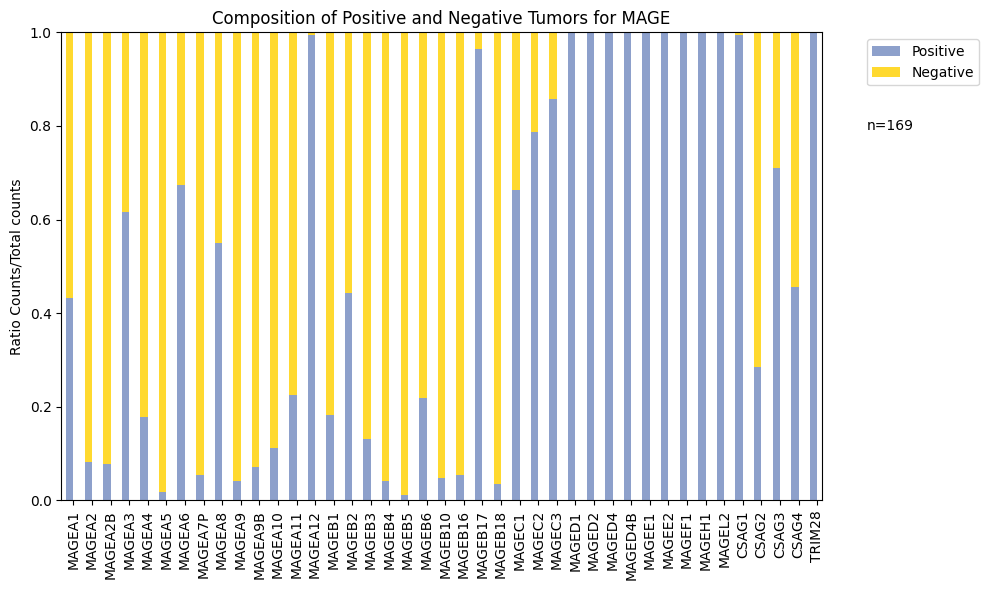

In [17]:
# Normalization
total_counts = no_zero + zero
positive_normalized = no_zero / total_counts
positive_normalized= positive_normalized[column_order]
negative_normalized = zero / total_counts
negative_normalized= negative_normalized[column_order]
# Set colors
colors_pastel = sns.color_palette("Set2")
# Stacked barplot
plt.figure(figsize=(10, 6))
positive_normalized.plot(kind='bar', color=colors_pastel[2], width=0.4, position=1, label='Positive')
negative_normalized.plot(kind='bar', color=colors_pastel[5], width=0.4, position=1, bottom=positive_normalized, label='Negative')
plt.title('Composition of Positive and Negative Tumors for MAGE')
plt.ylabel('Ratio Counts/Total counts')
plt.legend()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.text(1.09, 0.8, 'n=169', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()

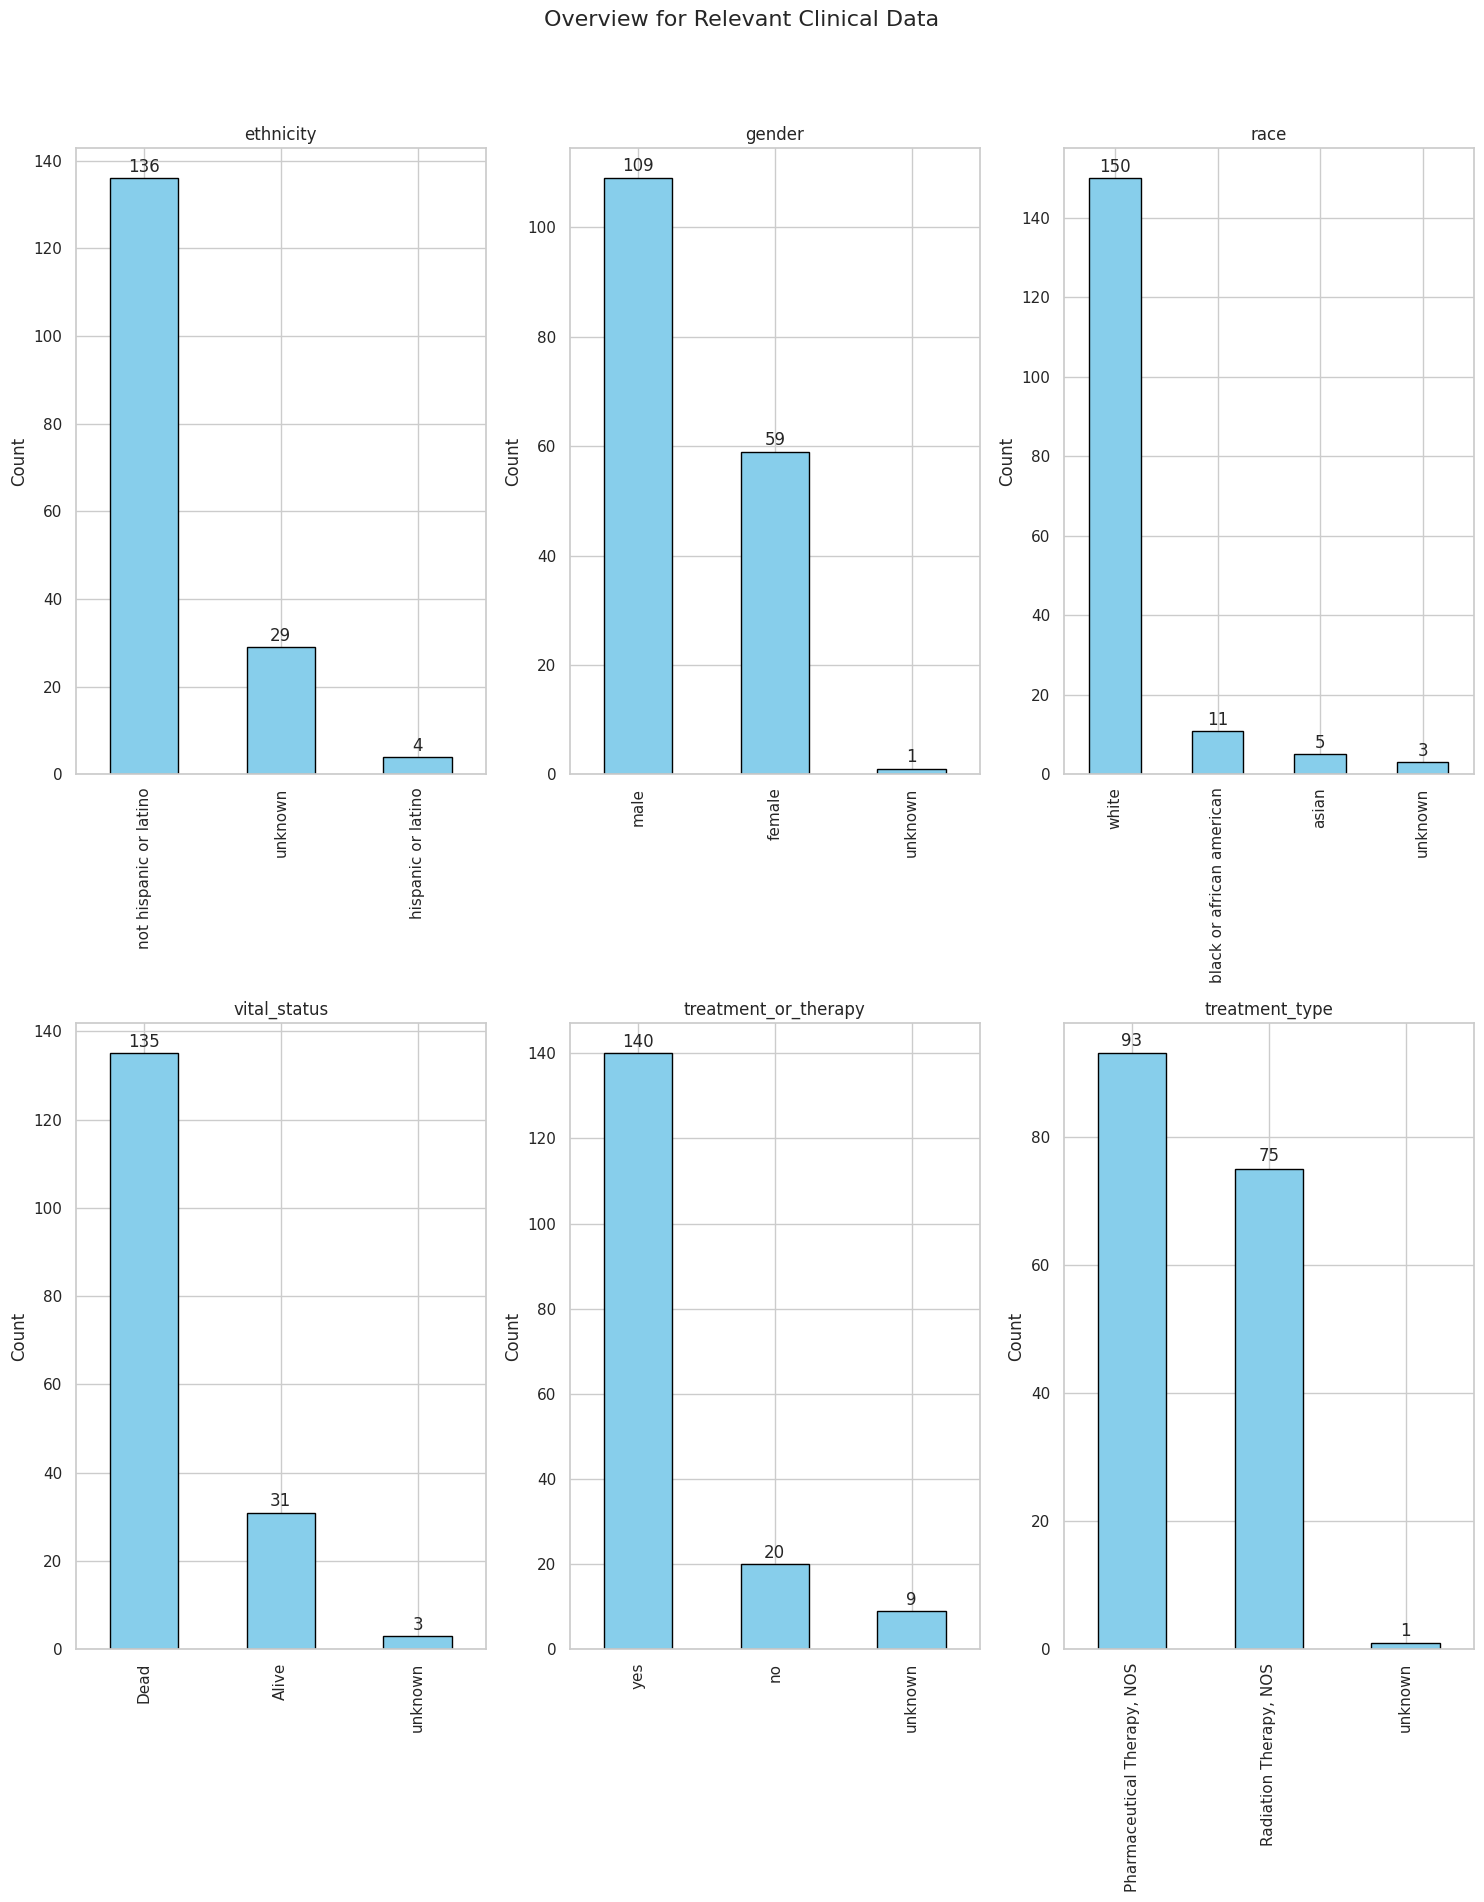

In [74]:
# Define columns for bar plots
columns_bar = ['ethnicity', 'gender', 'race', 'vital_status', 'treatment_or_therapy', 'treatment_type']
# Calculate the number of rows and columns needed for subplots
num_cols_bar = 3  # Number of columns in the subplot grid for bar plots
num_rows_bar = (len(columns_bar) + num_cols_bar - 1) // num_cols_bar  # Calculate the number of rows needed
# Create a figure and set its size
plt.figure(figsize=(15, 20))
# Set a title for the entire figure
plt.suptitle('Overview for Relevant Clinical Data', fontsize=16)
# Loop through each column and create a subplot
for i, column in enumerate(columns_bar, 1):
    plt.subplot(num_rows_bar, num_cols_bar, i)
    # Plot bar plot for the current column
    counts = df_filled[column].value_counts()
    counts.plot(kind='bar', color='skyblue', edgecolor='black')
    # Annotate each bar with the count value if possible
    for j, count in enumerate(counts):
        plt.text(j, count + 0.5, str(count), ha='center', va='bottom')
    # Remove x-axis label
    plt.xlabel('')
    # Set y-axis label
    plt.ylabel('Count')
    # Set title for the subplot
    plt.title(column)
# Adjust the layout to prevent overlapping of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the plot
plt.show()

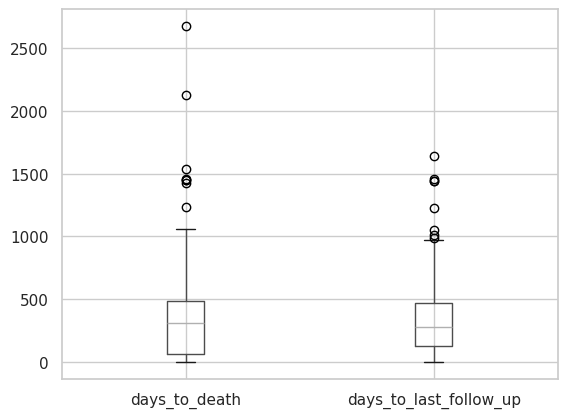

In [107]:
# Define columns for histograms
columns_histogram = ['days_to_death', 'days_to_last_follow_up']
# Fill NaN values with 0 in the specified columns
df_filled = df.copy()
df_filled[columns_histogram] = df_filled[columns_histogram].fillna(0)
# Extract the columns for the histogram
dfHistogram = df_filled[columns_histogram]
# Convert non-numeric columns to numeric without chaining
dfHistogram = dfHistogram.apply(pd.to_numeric, errors='coerce')
# Generate boxplot
dfHistogram.boxplot()
plt.show()

<h1><font color="#004D7F" size=5>3. Data exploration</font></h1>

In [26]:
genes = [
    "MAGEA1", "MAGEA2", "MAGEA2B", "MAGEA3", "MAGEA4", "MAGEA5", "MAGEA6", "MAGEA7P", "MAGEA8", "MAGEA9",
    "MAGEA9B", "MAGEA10", "MAGEA11", "MAGEA12", "MAGEB1", "MAGEB2", "MAGEB3", "MAGEB4", "MAGEB5", "MAGEB6",
    "MAGEB10", "MAGEB16", "MAGEB17", "MAGEB18", "MAGEC1", "MAGEC2", "MAGEC3", "MAGED1", "MAGED2", "MAGED4",
    "MAGED4B", "MAGEE1", "MAGEE2", "MAGEF1", "MAGEH1", "MAGEL2", "CSAG1", "CSAG2", "CSAG3", "CSAG4", "TRIM28"
]
# Extract unique categories from the 'gender' column
genders = df['gender'].unique()
# Initialize a dictionary to store counts
counts_dict = {'Gene': [], 'Gender': [], 'Positive': [], 'Negative': []}
# Iterate over each MAGE gene and sex
for gene in genes:
    for gender in genders:
        # Filter dataframe for the current MAGE gene and sex
        filtered_df = df[(df[gene] > 0) & (df['gender'] == gender)]   
        # Count positive and negative cases
        positive_count = filtered_df.shape[0]
        negative_count = df[(df[gene] == 0) & (df['gender'] == gender)].shape[0]
        # Append counts to the dictionary
        counts_dict['Gene'].append(gene)
        counts_dict['Gender'].append(gender)
        counts_dict['Positive'].append(positive_count)
        counts_dict['Negative'].append(negative_count)

# Create a new dataframe from the counts dictionary
counts_df = pd.DataFrame(counts_dict)
# Display the resulting dataframe
print(counts_df)

       Gene  Gender  Positive  Negative
0    MAGEA1    male        46        63
1    MAGEA1  female        27        32
2    MAGEA1     NaN         0         0
3    MAGEA2    male         8       101
4    MAGEA2  female         6        53
..      ...     ...       ...       ...
118   CSAG4  female        28        31
119   CSAG4     NaN         0         0
120  TRIM28    male       109         0
121  TRIM28  female        59         0
122  TRIM28     NaN         0         0

[123 rows x 4 columns]


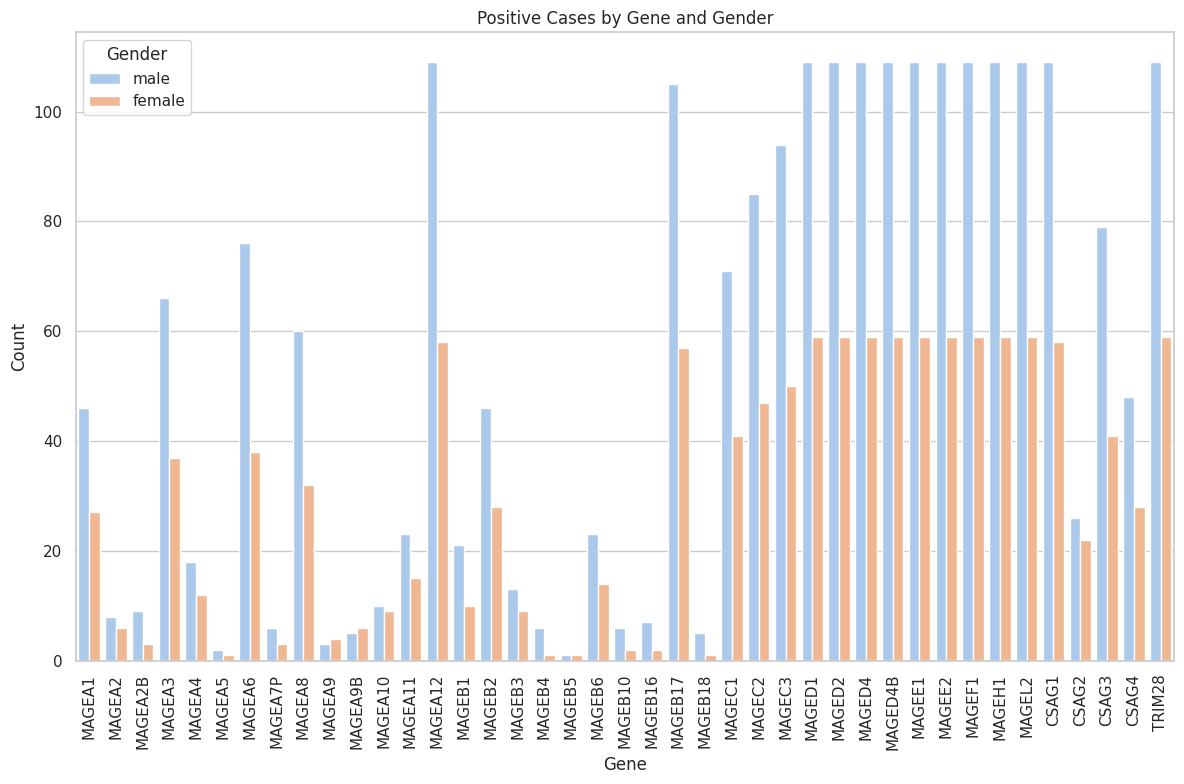

In [27]:
sns.set(style="whitegrid")

# Plot the grouped bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x='Gene', y='Positive', hue='Gender', data=counts_df, palette='pastel', errorbar=None)
plt.title('Positive Cases by Gene and Gender')
plt.xlabel('Gene')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

In [20]:
# Pairwise Pearson correlations
pd.set_option('display.width', 100)
pd.set_option('display.precision', 3)
correlation = df_numeric.corr(method ='pearson')
print(correlation)

            MAGEA1     MAGEA2    MAGEA2B     MAGEA3     MAGEA4  MAGEA5  MAGEA6    MAGEA7P  MAGEA8  \
MAGEA1   1.000e+00  1.888e-01  4.349e-05  2.573e-02  9.855e-01  -0.014   0.094 -2.867e-02   0.006   
MAGEA2   1.888e-01  1.000e+00 -3.989e-02 -1.972e-02  2.037e-01  -0.036  -0.036  8.903e-02  -0.010   
MAGEA2B  4.349e-05 -3.989e-02  1.000e+00  8.616e-03 -1.829e-02  -0.028   0.244 -4.974e-02   0.003   
MAGEA3   2.573e-02 -1.972e-02  8.616e-03  1.000e+00 -2.164e-05  -0.026   0.197 -3.600e-02   0.052   
MAGEA4   9.855e-01  2.037e-01 -1.829e-02 -2.164e-05  1.000e+00  -0.011   0.047 -1.966e-02   0.015   
MAGEA5  -1.368e-02 -3.611e-02 -2.770e-02 -2.621e-02 -1.114e-02   1.000  -0.051 -3.031e-02   0.029   
MAGEA6   9.421e-02 -3.565e-02  2.436e-01  1.971e-01  4.721e-02  -0.051   1.000 -5.212e-02  -0.011   
MAGEA7P -2.867e-02  8.903e-02 -4.974e-02 -3.600e-02 -1.966e-02  -0.030  -0.052  1.000e+00   0.008   
MAGEA8   6.437e-03 -1.004e-02  3.304e-03  5.182e-02  1.489e-02   0.029  -0.011  8.007e-03  